First Steps: gradCAM
- works for any model
- discriminates classes (change y_c index)

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
input_path = "C:/DL_Lab/Racoon_dataset/train/raccoon-20_jpg.rf.fb19aa368c074a61eed8829617ed6b7c.jpg"

(-0.5, 223.5, 223.5, -0.5)

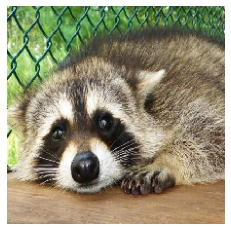

In [2]:
# load and import image with keras in RGB format
orig_image = load_img(input_path, target_size=(224,224))
image = img_to_array(orig_image) # scales to 0-255
image = preprocess_input(image)
image = np.expand_dims(image, axis=0)
plt.imshow(orig_image)
plt.axis("off")

In [3]:
# pretrained model
model = ResNet50(input_shape=(224,224,3), include_top=True, weights="imagenet")

In [4]:
# find last conv layer name and get model that ends with it
for layer in reversed(model.layers):
    # 'conv5_block3_out' with shape (None, 7, 7, 2048)
    if len(layer.output_shape) == 4:
        last_conv_layer = model.get_layer(layer.name)
        break
# returns conv fmaps and model prediction when called
gradModel = Model(inputs=[model.input], outputs=[last_conv_layer.output, model.output])

In [5]:
with tf.GradientTape() as tape:
    # get predictions from conv model and model
    (fmaps, preds) = gradModel(image)
    # get logit of winner-class
    y_c = preds[:,np.argmax(preds[:,])]

grads = tape.gradient(y_c, fmaps)[0]
grads.shape

TensorShape([7, 7, 2048])

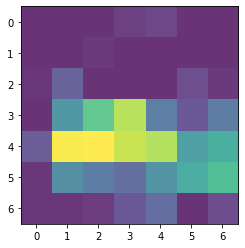

In [11]:
# apply global max pooling = collapse axes 0 and 1
weights = tf.reduce_mean(grads, axis=(0,1))
# calculate the class activation map
cam = tf.reduce_mean(fmaps[0] * weights, axis=2)
# apply relu 
cam = tf.nn.relu(cam)
plt.imshow(cam, cmap="viridis", alpha=0.8)

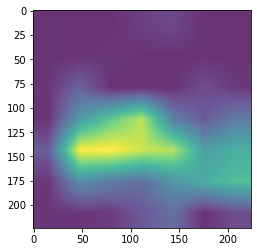

In [10]:
# upsample cam to original image size 224x224
ups_cam = cv.resize(cam.numpy(), (224, 224))
# normalize to range [0,1]
min = tf.math.reduce_min(ups_cam)
max = tf.math.reduce_max(ups_cam)
ups_cam = ((ups_cam - min) / (max - min))
plt.imshow(ups_cam, cmap="viridis", alpha=0.8)

(-0.5, 223.5, 223.5, -0.5)

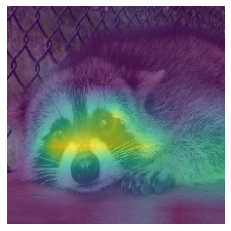

In [8]:
"overlay with open cv"
# change from 2d to 3d to match image shape
cam3d = np.expand_dims(ups_cam, axis=2)
cam3d = np.tile(cam3d, [1,1,3])
# opencv requires uint8 and [0,255]
cam3d = np.uint8(cam3d*255)
orig_image = np.uint8(orig_image)
# create colormap and convert to RGB
cam3d_hm = cv.applyColorMap(cam3d, cv.COLORMAP_VIRIDIS)
cam3d_hm = cv.cvtColor(cam3d_hm, cv.COLOR_BGR2RGB)
# overlay both images
overlay = cv.addWeighted(orig_image, 0.3, cam3d_hm, 0.7, 0)
plt.imshow(overlay)
plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

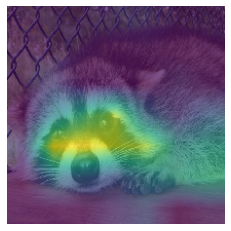

In [12]:
"overlay with open imshow"
plt.imshow(orig_image, alpha=1)
plt.imshow(ups_cam, cmap="viridis", alpha=0.7)
plt.axis("off")

Guided GradCAM